# Elaborating multiple annotators noise for non unequal image sized with U-NET

## Download and importing of libraries

In [1]:
# Install external libraries

!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git >> /tmp/null
!pip install wandb >> /tmp/null

  Running command git clone --filter=blob:none --quiet https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git /tmp/pip-req-build-8cj2upi2


In [2]:
# Native libraries
import os
import random
import warnings
from enum import auto, Enum
from functools import partial

# General use libraries
import numpy as np
import matplotlib.pyplot as plt

# External libraries #

# OpenCV librarie
import cv2

# Sklearn librarie and modules
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

# Tensorflow librarie and modules
import tensorflow as tf
from tensorflow import keras
from matplotlib.style import available
from tensorflow.keras.losses import Loss
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric
from tensorflow.keras.utils import to_categorical
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, Callback

# WanDB librarie and modules
import wandb
from wandb.keras import WandbCallback
from wandb.sklearn import plot_learning_curve

# GCPDS librarie and modules
from gcpds.image_segmentation.models import unet_baseline
from gcpds.image_segmentation.visualizations import plot_contour
from gcpds.image_segmentation.datasets.segmentation import OxfordIiitPet

2024-04-19 17:15:14.882324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-19 17:15:14.882440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-19 17:15:15.046835: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Download and condition of the Oxford Pet dataset 

In [3]:
dataset = OxfordIiitPet()
train_dataset, val_dataset, test_dataset = dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0IR4UL/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0IR4UL/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [4]:
BATCH_SIZE = 32
NUM_EPOCHS = 150
TARGET_SHAPE = 256, 256

def fussion_mask(mask: EagerTensor) -> EagerTensor:
    """Fuses the object and border masks into a single mask.

    This function takes a mask tensor containing separate channels for the object, 
    background, and border, and fuses the object and border channels into a single 
    mask channel.

    Parameters:
        mask (EagerTensor): A tensor representing the segmentation mask with 
            object, background, and border channels.

    Returns:
        EagerTensor: A tensor representing the fused mask containing the sum 
            of the object and border channels.

    """
    obj, bg, border = tf.unstack(mask, axis=2)
    orig_shape = mask.shape
    new_shape = list(orig_shape)
    new_shape[-1] = 1
    return tf.reshape(tf.stack([obj + border]), new_shape)


def map_dataset(dataset, target_shape, batch_size):
    """Preprocesses and batches a dataset for training or evaluation.

    This function applies a series of transformations to each sample in the dataset 
    to prepare it for training or evaluation. It resizes images and masks to the 
    specified target shape, fuses mask channels if needed, and batches the dataset.

    Args:
        dataset (tf.data.Dataset): The input dataset containing images, masks, labels, and IDs.
        target_shape (tuple): A tuple specifying the desired shape of images and masks.
        batch_size (int): The batch size to use for training or evaluation.

    Returns:
        A preprocessed and batched dataset ready for training or evaluation.

    """
    # Resize images and masks to the target shape
    dataset_ = dataset.map(lambda img, mask, label, id_img: (img, mask),
                           num_parallel_calls=tf.data.AUTOTUNE)
    dataset_ = dataset_.map(lambda img, mask: (tf.image.resize(img, target_shape), 
                                                tf.image.resize(mask, target_shape)),
                            num_parallel_calls=tf.data.AUTOTUNE)
    
    # Fuse mask channels if needed
    dataset_ = dataset_.map(lambda img, mask: (img, fussion_mask(mask)),
                            num_parallel_calls=tf.data.AUTOTUNE)

    # Batch the dataset
    dataset_ = dataset_.batch(batch_size)
    return dataset_

train = map_dataset(train_dataset, TARGET_SHAPE, BATCH_SIZE)
val = map_dataset(val_dataset, TARGET_SHAPE, BATCH_SIZE)
test = map_dataset(test_dataset, TARGET_SHAPE, BATCH_SIZE)

(32, 256, 256, 1)


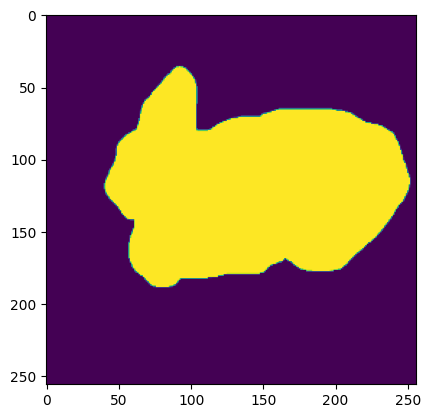

In [5]:
for img,mask in train.take(1):
  print(mask.shape)
  plt.figure()
  plt.imshow(mask[0][:,:,0])

## DICE Coefficient Loss

$$\text{DiceCoefficient}(y_{\text{true}}, y_{\text{pred}}) = - \frac{2 \cdot \text{intersection} + \text{smooth}}{\text{union} + \text{smooth}}$$

Where:

- $y_{\text{true}}$ represents the ground truth segmentation masks.
- $y_{\text{pred}}$ represents the predicted segmentation masks.
- $\text{intersection}$  calculates the sum of element-wise multiplication between $y_{\text{true}}$ and $y_{\text{pred}}$.
- $\text{union}$ calculates the sum of elements in both $y_{\text{true}}$ and $y_{\text{pred}}$.
- $\text{smooth}$ is a smoothing parameter to avoid division by zero.

In [6]:
# Definition of the DiceCoefficientLoss

class DiceCoefficient(Loss):
    
    """
    DiceCoefficient loss function.

    This loss function computes the Dice coefficient, a similarity metric commonly
    used in image segmentation tasks. It measures the overlap between the predicted
    segmentation mask (y_pred) and the ground truth mask (y_true).
    
    Methods
    ----------
    call(y_true, y_pred)
    get_config()
    """
    
    def __init__(self, smooth=1., target_class= None, name='DiceCoefficient', **kwargs):
        """
        Initializes the DiceCoefficient loss object.

        Parameters:
            smooth (float): A smoothing parameter to avoid division by zero. Defaults to 1.0.
            target_class (int or None): If specified, computes the Dice coefficient only for 
                the specified class index. If None, computes the average Dice coefficient 
                across all classes. Defaults to None.
            name (str): Name of the loss function. Defaults to 'DiceCoefficient'.
            **kwargs: Additional arguments passed to the parent class.
        """
        self.smooth = smooth
        self.target_class = target_class
        super().__init__(name=name,**kwargs)

    def call(self, y_true, y_pred):
        """
        Computes the Dice coefficient loss.

        Parameters:
            y_true (tensor): Ground truth segmentation masks.
            y_pred (tensor): Predicted segmentation masks.

        Returns:
            A tensor representing the Dice coefficient loss.
        """
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2])
        dice_coef = -(2. * intersection + self.smooth) /(union + self.smooth)

        if self.target_class != None:
            dice_coef = tf.gather(dice_coef,
                                  self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef,axis=-1)

        return dice_coef

    def get_config(self,):
        """
        Gets the configuration of the loss function.

        Returns:
            A dictionary containing the configuration parameters of the loss function.
        """
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}

## Definition of performance metrics

### DICE metric

$$\text{Dice} = {2 \cdot |\text{Intersection}| + \text{smooth} \over |\text{Union}| + \text{smooth}}$$

Where:

$|\text{Intersection}| = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $|\text{Union}| = \sum_{i=1}^{N} y\_{true\_i} + \sum_{i=1}^{N} y\_{pred\_i}$


- $N$ is the total number of elements in the segmentation masks.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted segmentation masks, respectively.
- $\text{smooth}$ is a smoothing parameter to avoid division by zero.

In [7]:
# Definition of the DiceCoefficientMetric

def dice_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    """Computes the Dice coefficient metric for evaluating semantic segmentation.

    This function calculates the Dice coefficient metric, which measures the similarity 
    between ground truth and predicted segmentation masks.
    Parameters:
        y_true (tensor): Ground truth segmentation masks.
        y_pred (tensor): Predicted segmentation masks.
        axis (tuple of int): Axis along which to compute sums. Defaults to (1, 2).
        smooth (float): A smoothing parameter to avoid division by zero. Defaults to 1e-5.

    Returns:
        A scalar value representing the average Dice coefficient metric.

    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

### Jaccard metric

$$\text{Jaccard} = {|\text{Intersection}| + \text{smooth} \over |\text{Union}| + \text{smooth}}$$

Where:

$|\text{Intersection}| = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $|\text{Union}| = \sum_{i=1}^{N} y\_{true\_i} + \sum_{i=1}^{N} y\_{pred\_i} - |\text{Intersection}|$
- $N$ is the total number of elements in the segmentation masks.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted segmentation masks, respectively.
- $\text{smooth}$ is a small smoothing parameter to avoid division by zero.

In [8]:
# Definition of the JaccardMetric

def jaccard_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    """Computes the Jaccard similarity coefficient as a metric for semantic segmentation.

    The Jaccard similarity coefficient, also known as the Intersection over Union (IoU),
    measures the similarity between two sets by comparing their intersection to their union.
    In the context of semantic segmentation, it quantifies the overlap between the ground
    truth segmentation masks and the predicted segmentation masks.

    Parameters:
        y_true (tensor): Ground truth segmentation masks.
        y_pred (tensor): Predicted segmentation masks.
        axis (tuple of int): Axes along which to compute sums. Defaults to (1, 2).
        smooth (float): A small smoothing parameter to avoid division by zero. Defaults to 1e-5.

    Returns:
        A tensor representing the mean Jaccard similarity coefficient.

    """
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(jaccard)

### Sensitivity metric

$$\text{Sensitivity} = {\text{True Positives} \over \text{Actual Positives} + \text{smooth}}$$

Where:

$\text{True Positives} = \sum_{i=1}^{N} y\_{true\_i} \cdot y\_{pred\_i}$, $\text{Actual Positives} = \sum_{i=1}^{N} y\_{true\_i}$


- $N$ is the total number of elements in the labels.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the value of the i-th element in the ground truth and predicted labels, respectively.
- $\text{smooth}$ is a small value added to the denominator to avoid division by zero.

In [9]:
# Definition of the SensitivityMetric

def sensitivity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    """Computes the sensitivity as a metric for semantic segmentation.

    Sensitivity, also known as true positive rate or recall, measures the proportion 
    of actual positives that are correctly identified by the model. It is computed 
    as the ratio of true positives to the sum of true positives and false negatives.

    Parameters:
        y_true (tensor): Ground truth labels.
        y_pred (tensor): Predicted probabilities or labels.
        axis (tuple): Axes over which to perform the reduction. Defaults to (1, 2).
        smooth (float): A small value added to the denominator to avoid division by zero. 
            Defaults to 1e-5.

    Returns:
        The sensitivity metric averaged over the specified axes.

    """
    true_positives = tf.reduce_sum(y_true * y_pred, axis=axis)
    actual_positives = tf.reduce_sum(y_true, axis=axis)
    sensitivity = true_positives / (actual_positives + tf.keras.backend.epsilon())
    return tf.reduce_mean(sensitivity)

### Specificity metric

$$\text{Specificity} = {\text{True Negatives} \over \text{Actual Negatives} + \text{smooth}}$$

Where:

$\text{True Negatives} = \sum_{i=1}^{N} (1 - y\_{true\_i}) \cdot (1 - y\_{pred\_i})$, $\text{Actual Negatives} = \sum_{i=1}^{N} (1 - y\_{true\_i})$

- $N$ is the total number of samples.
- $y\_{true\_i}$ and $y\_{pred\_i}$ represent the ground truth label and predicted probability (or binary prediction) for the i-th sample, respectively.
- $\text{smooth}$ is a smoothing term to avoid division by zero.

In [10]:
# Definition of the SpecificityMetric

def specificity_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    """Computes the specificity as a metric for semantic segmentation.

    Specificity measures the proportion of actual negative cases that were correctly 
    identified as such. It is complementary to sensitivity (recall).

    Parameters:
        y_true (tensor): Ground truth binary labels.
        y_pred (tensor): Predicted probabilities or binary predictions.
        axis (tuple): Axes over which to perform reduction. Defaults to (1, 2).
        smooth (float): Smoothing term to avoid division by zero. Defaults to 1e-5.

    Returns:
        A tensor representing the specificity metric.

    """
    true_negatives = tf.reduce_sum((1 - y_true) * (1 - y_pred), axis=axis)
    actual_negatives = tf.reduce_sum(1 - y_true, axis=axis)
    specificity = true_negatives / (actual_negatives + tf.keras.backend.epsilon())
    return tf.reduce_mean(specificity)

## Start and define items to register with WanDB

In [11]:
# WanDB Credentianls for login (optional)
wandb_active = True
wandb.login(key="YourWanDBAPIKey")

# Definition metrics to record with WanDB

class WandbCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Records the Loss value and metrics at the end of each epoch
        wandb.log({'Epoch': epoch, 'Loss': logs['loss'], 'Jaccard': logs['jaccard_metric'], 'Sensitivity': logs['sensitivity_metric'], 
                   'Specificity': logs['specificity_metric'], 'Dice': logs['dice_metric'], 
                   'val_Loss': logs['val_loss'], 'val_Jaccard': logs['val_jaccard_metric'], 'val_Sensitivity': logs['val_sensitivity_metric'],
                  'val_Specificity': logs['val_specificity_metric'],'val_Dice': logs['val_dice_metric']})

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Assembling UNet with Loss DICECoefficient and metrics

In [12]:
model = unet_baseline(input_shape= TARGET_SHAPE + (3,), out_channels=1)
model.compile(
    loss=DiceCoefficient(),
    optimizer="adam",
    metrics = [dice_metric, jaccard_metric, sensitivity_metric, specificity_metric]
    )
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch00             │ (None, 256, 256,  │         12 │ input_layer[0][0] │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv10 (Conv2D)     │ (None, 256, 256,  │        224 │ Batch00[0][0]     │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch10             │ (None, 256, 256,  │         32 │ Conv10[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv11 (Conv2D)     │ (None, 256, 256,  │        584 │ Batch10[0][0]     │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch11             │ (None, 256, 256,  │         32 │ Conv11[0][0]      │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool10              │ (None, 128, 128,  │          0 │ Batch11[0][0]     │
│ (MaxPooling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv20 (Conv2D)     │ (None, 128, 128,  │      1,168 │ Pool10[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch20             │ (None, 128, 128,  │         64 │ Conv20[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv21 (Conv2D)     │ (None, 128, 128,  │      2,320 │ Batch20[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch22             │ (None, 128, 128,  │         64 │ Conv21[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool20              │ (None, 64, 64,    │          0 │ Batch22[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv30 (Conv2D)     │ (None, 64, 64,    │      4,640 │ Pool20[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch30             │ (None, 64, 64,    │        128 │ Conv30[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv31 (Conv2D)     │ (None, 64, 64,    │      9,248 │ Batch30[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Batch31             │ (None, 64, 64,    │        128 │ Conv31[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Pool30              │ (None, 32, 32,    │          0 │ Batch31[0][0]   

 Total params: 494,093 (1.88 MB)

 Trainable params: 492,615 (1.88 MB)

 Non-trainable params: 1,478 (5.77 KB)

![Network](https://lh3.googleusercontent.com/fife/ALs6j_GCnnXDhir_x6s3AwBWeF_KMeU2jgsis6Sg9hmp4y2-Yz9X1gUXxIAM6hQwDAWZoJqLSybhDDdyWhB7cTf27JluP3V8HCxFZWtivUlAmf15ocGIbH1gFobiv98nLWKOJTWJjfmOH1vhKqQmfHeWOiArgM4aCcbYQVsihMLyS5hOrJcMCqKvLQ2q4ZKInRjt85r31Rt25Jtqb5JLwSOJdYz5YUxgmBPI79Z_h25SUJygvAolN2GQ0nFIxeGAo-bLpBnu1TTefYt-Gis4qXhVYJdBRyWB_nwddRmQVKoAQo_CcHkdpQ6XsDBIR0H5L3RFPPi7WSG660kum0V77CgLwEY3WEXpkuMvlavlF1zTQNzm6zEOnFG9UF26aGJK2MiG5nqPTyKs2jTXfa4qq-TjktzGUXT44h6GIKe8WLbNOlZL8JKxqOLCB2yejYL2GA0iy7_gw8tJJhSWmHC_U4ueN7CBQTuVK94XwTyH7mLnhR5XPYDT0fKitgiEy45WhT2qlEzvINGTKhO1WZDFTcfxY5alu-mhco3R5G6rpxemUFMss0_CyjU4CIpCa15eQusiI34ycW1InD6hTfUX7ph-eqGbh8LYZ-pnDaynt_uX95td2Gl5hUYNwOFyCviLkTeaAHFBf3tMWuHc7ZHel9DPr3ORofF1vSWdqWM1RAFvBL18u3BC_ZDTVi3CecqOP4gCnEYIU7xtjQAEbfmHlQI4GYvSwkpOU6mocWITWeO36uDUONrWVyDDOgBp4yIF1Tot-zfCQca9KXrOP035ieQaLVp3la9ffWsOLiFFfe970C7v-ICCMhWEXndWkzsLPn8IinHZttQDrRT5BBreDwSFr3OzOljOW-FFKd-8ZBRI3lIuXonMKGF2fCVUgALuRv_0W7sJ0WG64NxzWN48ixMLcAZUBVzRgZvdhL8TKkXrPeGTsPoBe-zc92fumGryUDks1gYA44QFDcvmxrquCjDgyUEKHlTomxzBdaSLbfhrAfgq96Qi-5GbRaSvJR4YiBVd27bmaEBKqyNnsv8hyX66ZKKtsFqLc3SiOl0-FtmYRHwX-hRm4JLTXi8x0FzoUe69U-myEofNOlWFhs_OgLn5TLQx0VisZ87BhK8TCvJa3I1csna3FWDcjW0zQPXJDcNiUxZE12G4_jeE-G92GdvBSeusW8BdUGKH85lqC99eH4K1yeET5YUCil6HbADoI5t3ouYJstsrTvGuywrtaNrdriq1PR1Jl_qXg9jH5By-nZoI8IbotAkFUzyIZ_-qGpToRPpmcab5TKKh2BFb2jxek1icVvOG5xph5I_UTKQ0fyDXAGnP5FEOl6VmYs_F-ylh54hRK92eA1tx11eG3t0i_PydrUaLNr77cprWxmffgZ0gAiMeuQ00gX1-clq2Ed2XFKtkkhKOSgz2ro9uW0zYmtyqfy-P_qGZX5mst6LOx1QJwiZw_7se8Gq3oxTuzSdmCcxoPHYVjtsO5jqBl_Y-fC4NZpt0HP2q-8hCQxL2g7RjXehqWe7gm96mgekZW8RGTygwtUnN-Vtdbo1rgIOciz--sNOdsLrMef3m8P8UPNkLhXTPLZqGCoEAl32DHiNTiyaa9Oy5bAH43mFaMaIGaB55r3V9CiTZZ6m6CbQvlf7i8tBtMBbDBoU2vQggpcbYQkyDZqlOmkbETqMadyk=w1632-h928)

## Training section

In [ ]:
if wandb_active == True:
    run = wandb.init(config= None, project='YourNameProject', entity='YourEntity')
    wandb.config.dataset_name = "OxfordPets"
    wandb.config.architecture_name = "UNet"
    model.fit(train,validation_data=val,epochs=NUM_EPOCHS,callbacks=[WandbCallback()])
    model.save(f'{model.name}.h5')
    model.save(f'{model.name}.keras')
    wandb.save(f'{model.name}.h5')
    wandb.save(f'{model.name}.keras')
    run.finish()
else:
    model.fit(train,validation_data=val,epochs=NUM_EPOCHS)
    model.save(f'{model.name}.h5')
    model.save(f'{model.name}.keras')

## Plotting of model training history

In [14]:
def display_learning_curves(history,NUM_EPOCHS):
    """Display the learning curves of training and validation loss over epochs.

    This function plots the training and validation loss over the specified number of epochs
    to visualize the learning progress of a neural network model.

    Parameters:
        history (History): A History object containing the training history of the model.
        NUM_EPOCHS (int): The total number of epochs for which the model was trained.

    Returns:
        None

    """
    # Extracting loss values
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    # Generating epoch range
    epochs_range = range(NUM_EPOCHS)  # Assuming NUM_EPOCHS is defined

    # Creating figure
    fig = plt.figure(figsize=(12, 6))

    # Plotting loss curves
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validation loss")

    # Adding titles and labels
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    # Adjusting layout
    fig.tight_layout()

    # Displaying grid and plot
    plt.grid()
    plt.show()

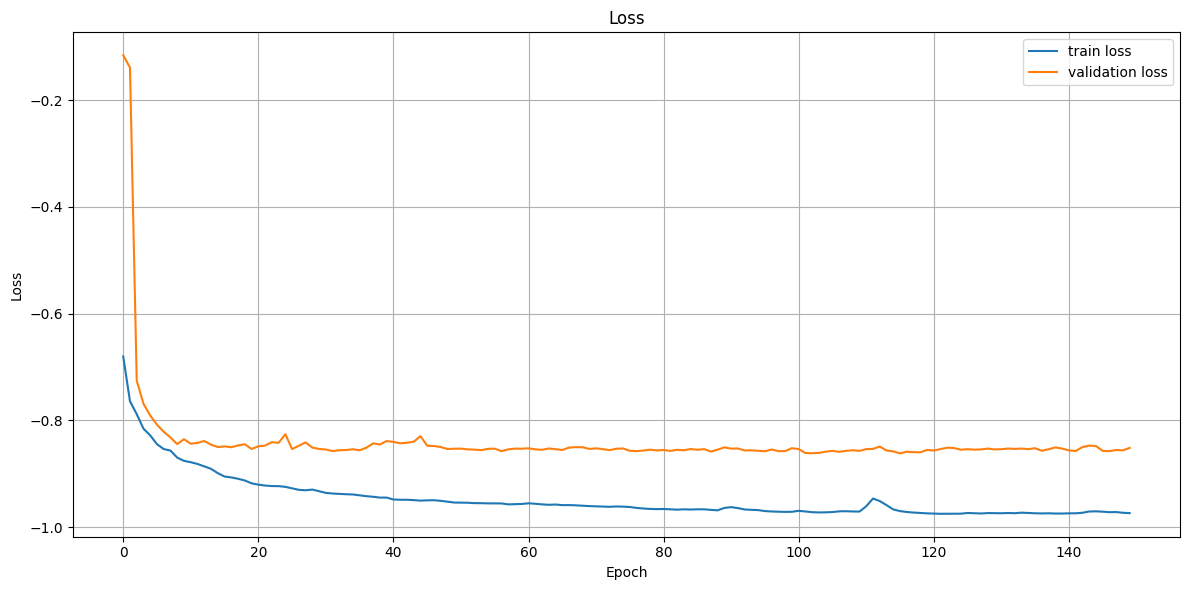

In [15]:
display_learning_curves(model.history,NUM_EPOCHS)

## Prediction and plotting of model predictions to test data

In [16]:
def create_mask(pred_mask):
    """Creates a segmentation mask from the predicted mask tensor.

    Parameters:
        pred_mask (tensor): Predicted mask tensor with shape (height, width, num_classes).

    Returns:
        A segmentation mask tensor with shape (height, width, 1), where each pixel 
        represents the predicted class index.

    """
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [17]:
def display(display_list, dice):
    """Displays images and masks in a row with titles.

    This function creates a visualization of images and masks in a row, with titles 
    for each component. It is commonly used to visualize input images, true masks, 
    and predicted masks in semantic segmentation tasks.

    Parameters:
        display_list (list): A list containing the images/masks to be displayed.
        dice (float): The Dice coefficient value to be included in the title of 
            the predicted mask image.

    Returns:
        None

    """
    plt.figure(figsize=(15, 15))
    title = ["Input Image", "True Mask", f"Predicted Mask (dice={dice:.3f})"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis("off")
    plt.show()

In [18]:
dice_coef = DiceCoefficient()

def show_predictions(model, dataset, num=1):
    """Displays predictions of a model on a dataset along with ground truth masks.

    This function takes a trained model and a dataset containing input images and 
    corresponding ground truth masks, generates predictions using the model, and 
    displays the original image, ground truth mask, and predicted mask for visualization.

    Parameters:
        model (tensorflow.keras.Model): A trained segmentation model.
        dataset (tensorflow.data.Dataset): A dataset containing input images and 
            corresponding ground truth masks.
        num (int): Number of samples from the dataset to visualize. Defaults to 1.

    Returns:
        None

    """
    for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        # Assuming dice_coef.call is an instance of DiceCoefficient class
        dice = dice_coef.call(mask, pred_mask)
        display([image[0], mask[0], pred_mask[0]], np.abs(dice[0]))


In [19]:
count = 0
for i in test_dataset:
    count +=1
print("number of batches:", count)

number of batches: 552


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


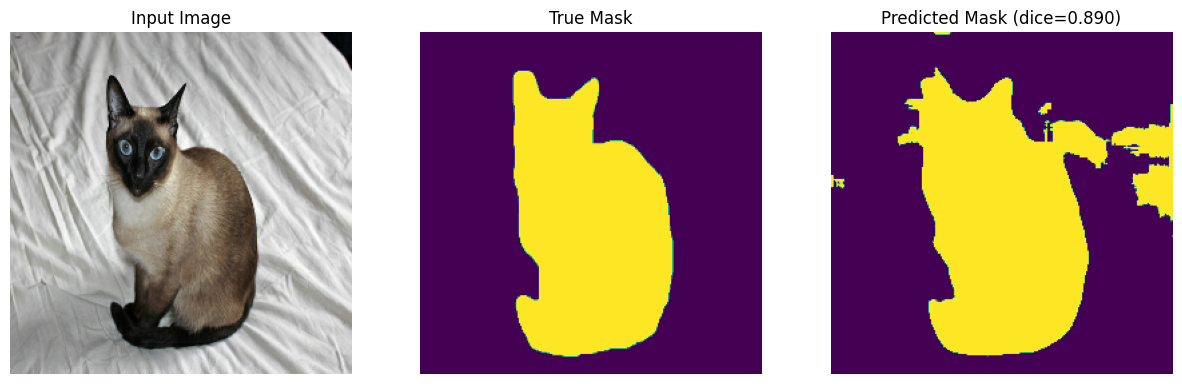

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


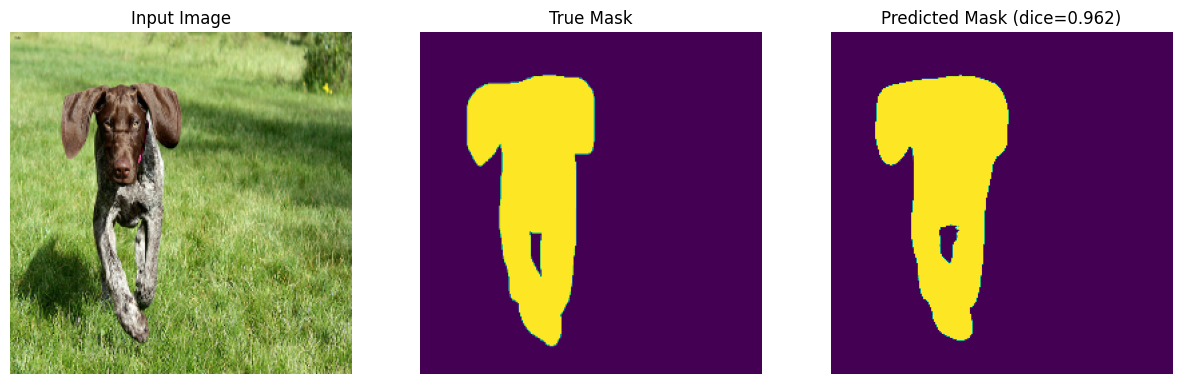

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


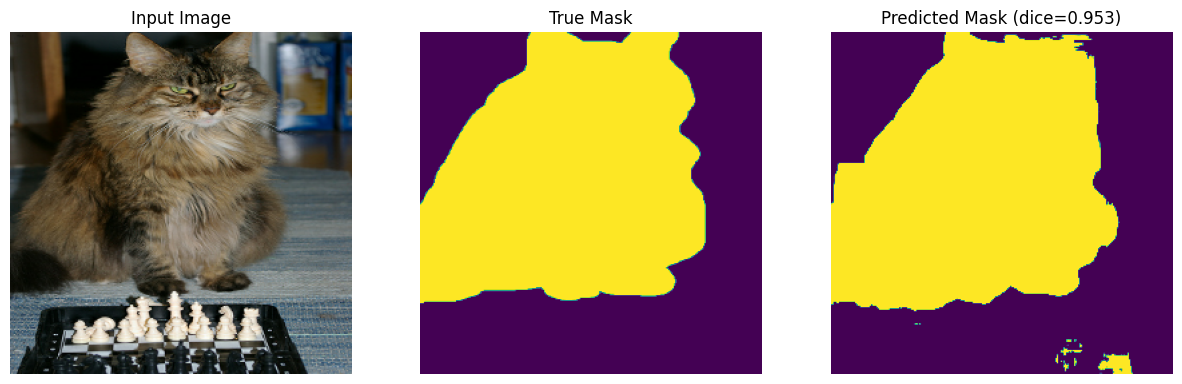

In [20]:
show_predictions(model, test.skip(5), 3)

## Calculation of DICE Coeficcient on test data

In [21]:
dice_coef = DiceCoefficient()

def calculate_dice_values(model, dataset):
    """Calculates the Dice coefficient values for a given model and dataset.

    This function computes the Dice coefficient values for each image-mask pair 
    in the dataset using the provided model. It iterates through the dataset, 
    generates predicted masks using the model, and computes the Dice coefficient 
    for each pair of ground truth and predicted masks.

    Parameters:
        model (keras.Model): The segmentation model used for prediction.
        dataset (tf.data.Dataset): The dataset containing image-mask pairs.

    Returns:
        numpy.ndarray: An array containing the Dice coefficient values for each image-mask pair.

    """
    dice_values = []
    for image, mask in dataset:
        pred_mask = model.predict(image, verbose=0)
        [dice_values.append(dice_coef.call(mask[i], pred_mask[i])) for i in range(mask.shape[0])]
    return np.array(dice_values)


def calc_avg_dice(model, dataset):
    """Calculates the average Dice coefficient for a given model and dataset.

    This function computes the average Dice coefficient across all samples in the dataset
    using the specified model.

    Args:
        model (tensorflow.keras.Model): The segmentation model to evaluate.
        dataset (tf.data.Dataset): The dataset containing the segmentation data.

    Returns:
        float: The absolute value of the mean Dice coefficient across all samples.

    """
    dice_values = calculate_dice_values(model, dataset)
    mean_dice = dice_values.mean()
    normal_esc_seq = "\u001b[0m"
    bold_esc_seq = "\u001b[1m"
    magenta_esc_seq = "\u001b[35m"
    print(f"{magenta_esc_seq}================\n {bold_esc_seq}Mean dice:{np.abs(mean_dice):.3f} {normal_esc_seq}{magenta_esc_seq}\n================\n")
    return np.abs(mean_dice)

In [22]:
mean_dice = calc_avg_dice(model, test)

 Mean dice:0.822 



## Save model

In [23]:
from datetime import datetime
model_path = f"oxford_pet_model_no_border{datetime.now()}_dice{mean_dice:.3f}.keras"

In [24]:
model.save(filepath = model_path)